In [1]:
import pdb
import glob
import copy
import timeit
import numpy as np
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

#from dask.distributed import Client
#client = Client()  # start a local Dask client
#print(client)

## Specify data directories. 

According to Andrew Schuh:

> File locations on hercules:
> 
> `/work/noaa/co2/aschuh/WOMBAT_stuff/wombat-v3-forward`
> 
> `/work/noaa/co2/aschuh/WOMBAT_stuff/wombat-v3-inverse`
> 
> 4D Jacobian fields will be in `forward` and the postprocessed observational Jacobians will be in `inverse`.

> The TM5 versions are in
> 
> `/work/noaa/co2/andy/Projects/WOMBAT/wombat-v3-forward`
> 
> Transport stuff is in 3b. Output sensitivities are in 4b.

And according to Mike Bertolacci:

> There are three run directories, all in
>
> `3a_transport_gc/intermediates`:
> 
> - `runs`: most of the basis-function runs are here. These are split out by gpp/resp/ocean, region, pft for resp and gpp, component (intercept/trend/sin/cos/residual), and for the residual by month. Some combinations of region and pft are omitted due to negligible fluxes.
>
> - `runs-correction`: adds a few cases missing from the above
>
> - `runs-control`: has "control runs" where each major component + inventory is run, plus fires and fossil fluxes. These are not split out by region or month, and cover some cases that are omitted in the jacobian due to negligible fluxes.

### Update 12/8/25:

Mike suggests looking only at the control runs for now, and investigating both the mole fraction and flux data in tandem to understand what's happening. The flux field (emissions corresponding to each basis function) are in the `HEMCO_diagnostics` files.

In [2]:
data_dir = '/work/noaa/co2/aschuh/WOMBAT_stuff'
inverse_dir = f'{data_dir}/wombat-v3-inverse'
forward_dir = f'{data_dir}/wombat-v3-forward'
gc_transport_dir = f'{forward_dir}/3a_transport_gc/intermediates/runs-control'

def lev_to_p(lev):
    '''
    Converts level index to pressure in hPa
    '''
    df = pd.read_fwf("levels47.csv",skiprows=3,
                     names=["L", "eta_edge", "eta_mid", "alt_km", "p_hpa"])
    # keep only midpoint rows
    mid = df[df["eta_mid"].notna()].reset_index(drop=True)
    # get pressure
    return float(mid.loc[mid["L"] == lev, "p_hpa"].iloc[0])
def lev_to_z(lev):
    '''
    Converts level index to altitude in km
    '''
    df = pd.read_fwf("levels47.csv",skiprows=3,
                     names=["L", "eta_edge", "eta_mid", "alt_km", "p_hpa"])
    # keep only midpoint rows
    mid = df[df["eta_mid"].notna()].reset_index(drop=True)
    # get pressure
    return float(mid.loc[mid["L"] == lev, "alt_km"].iloc[0])

## Choose source, read components via tracer mappings from file

According to Mike:

> For each run directory there is a mapping.csv file that tells you how things work.

> The first few lines are:
>
> `---`
> 
> `basis_function, run, species`
> 
> `background_climatology_20140901, climatology_20140901_part001, r0001p001s001`
> 
>`ocean_intercept_regionRegion01, climatology_20140901_part001, r0001p001s002`
>
> `---`
>
> Here:
> 
> - The first column tells you the name of the basis function
> 
> - The second column tells you which run directory to find it in
>
> - The third column tells you the tracer name within that run
>
> - Here, the first `background` row is a simple run with no fluxes starting with a 400ppm IC
>
> - The second row is one for the ocean intercept in region 1 (you can tell from the name).
>
> All basis function runs start from a 400ppm IC


> Let's try to find the `ocean_intercept_regionRegion01` tracer:
> 
> - In `3a_transport_gc/intermediates/runs/` you will find directories like: `climatology_20140901_part001_split01`, `climatology_20140901_part001_split02`, and so on
>
> - This is a split over time, here each run runs for 3 months
Inside each directory you can find an `OutputDir`, which has daily files like `GEOSChem.SpeciesConcThreeHourly.YYYYMMDD_0000z.nc4`; these are the 3 hourly concentrations
>
> - In these files you will find `SpeciesConcVV_r0001p001s002` (among others). Matching up to the `mapping.csv`, you can tell this is for `ocean_intercept_regionRegion01`
>
> To post-process these files to get the jacobian, you just need to subtract 400ppm off them.


In [3]:
def get_mf_and_flux_for_split(source, lev, split, lat=None, lon=None, pft=None, substr=None, resample='1D', return_flux=True, return_mf=True, quiet=False):
    '''
    Reads, resamples, and returns mole fraction and flux data for a chosen emission source, 
    either globally or for a single lat/lon position

    Parameters
    ----------
    source : str
        either 'ocean', 'gpp', or 'resp'
    lev : int
        vertical level
    split : int
        an integer giving the time split number
    lat : float, optional
        latitude to extract data across time
    lon : float, optional
        longitude to extract data across time
    pft : int, optional
        an integer from 1 to 15 giving the plant functional type. Required if source=gpp or resp.
    resample : str, optional
        a valid time string to pass to xarray.resample. Default is '1D', which causes the returned data
        to be resampled to a daily frequency
    '''

    if(source == 'gpp' or source == 'resp'):
        assert pft is not None, 'pft must be supplied if source if gpp or resp'
        pfx, sfx = 'sib4_', f'_pft{pft:02d}'
        if(source == 'resp'): source = 'resp_tot'
    elif(source == 'ocean'): 
        source = 'ocean_lschulz'
        pfx, sfx = '', ''
    assert ((lon is None and lat is None) or (lat is not None and lon is not None)), \
            "lat and lon must both be supplied or not"

    # get mapping file
    mapping = pd.read_csv(f'{gc_transport_dir}/mapping.csv')
    
    # lambda function for formatting file names per input component
    fname = lambda component: f'control_{pfx}{source}_{component}{sfx}'
    
    # make dict of component labels -> component names
    if(source == 'ocean_lschulz'):
        comp_labels = ['intercept', 'trend', 'sin1', 'sin2', 'cos1', 'cos2', 'residual']
        comp_names  = dict(zip(comp_labels, ['intercept', 'trend', 'sin12_1', 'sin12_2', 
                                             'cos12_1', 'cos12_2', 'residual']))
    else:
        comp_labels = ['intercept', 'trend', 'sin1', 'sin2', 'sin3', 'cos1', 'cos2', 'cos3', 'residual']
        comp_names  = dict(zip(comp_labels, ['intercept', 'trend', 'sin12_1', 'sin12_2', 'sin12_3', 
                                             'cos12_1', 'cos12_2', 'cos12_3', 'residual']))
    
    # make dict of component labels -> maps
    comp_maps = dict(zip(comp_labels, [mapping[mapping['basis_function'] == fname(comp_names[comp])] 
                                   for comp in comp_labels]))
    comp_runs = dict(zip(comp_labels, [comp_maps[comp]['run'].iat[0] for comp in comp_labels]))
    comp_species = dict(zip(comp_labels, [comp_maps[comp]['species'].iat[0] for comp in comp_labels]))

    # ----------- get flux field data -----------
    # contatenate all files for this split
    # coarsen 1-hourly data to daily-mean
    if(return_flux):
        print(f'reading flux data for level {lev} = {lev_to_p(lev)} hPa = {lev_to_z(lev)} km')
        start_time = timeit.default_timer()
        comp_flux_data = {}
        for i,comp in enumerate(comp_labels):
            data_files = sorted(glob.glob(f'{gc_transport_dir}/{comp_runs[comp]}_split{split:02d}'\
                                           '/OutputDir/HEMCO_diagnostics*'))
            if(substr is not None):
                data_files = np.array(data_files)[[substr in v for v in data_files]]
            
            N    = len(data_files)
            data = [0]*N
            for j in range(N):
                if(not quiet):
                    print(f'reading {source} flux {comp} file {j+1}/{N}...')
                data_1hr = xr.open_dataset(data_files[j])[f'Emis_{comp_species[comp]}']
                data_1hr = data_1hr.isel(lev=lev-1)
                if(lat is not None):
                    data_1hr = data_1hr.sel(lat=lat, lon=lon, method='nearest')
                #print(f'resampling...'+''.join([' ']*50), end='\r')
                data[j] = data_1hr.resample(time=resample).mean()
                data[j] = (data[j]*1e6) - 400 # convert to ppm and subtract 400ppm
            #print(f'concatenating {comp} data ({N} files)...')
            data = xr.concat(data, dim='time')
            comp_flux_data[comp] = data
        
        elapsed = timeit.default_timer() - start_time
        print(f'took {elapsed:.2f} s')

    
    # ----------- get mole fraction data -----------
    # contatenate all files for this split
    # coarsen 3-hourly data to daily-mean
    # scale to ppm and remove 400ppm IC
    if(return_mf):
        print(f'reading mole fraction data for level {lev} = {lev_to_p(lev)} hPa = {lev_to_z(lev)} km')
        start_time = timeit.default_timer()
        comp_mf_data = {}
        for i,comp in enumerate(comp_labels):
            data_files = sorted(glob.glob(f'{gc_transport_dir}/{comp_runs[comp]}_split{split:02d}'\
                                           '/OutputDir/GEOSChem.SpeciesConcThreeHourly*'))
            if(substr is not None):
                data_files = np.array(data_files)[[substr in v for v in data_files]]
                
            N    = len(data_files)
            data = [0]*N
            for j in range(N):
                if(not quiet):
                    print(f'reading {source} mole fraction {comp} file {j+1}/{N}...', end='\r')
                data_3hr = xr.open_dataset(data_files[j])[f'SpeciesConcVV_{comp_species[comp]}']
                data_3hr = data_3hr.isel(lev=lev-1)
                if(lat is not None):
                    data_3hr = data_3hr.sel(lat=lat, lon=lon, method='nearest')
                #print(f'resampling...'+''.join([' ']*50), end='\r')
                data[j] = data_3hr.resample(time=resample).mean()
                data[j] = (data[j]*1e6) - 400 # convert to ppm and subtract 400ppm
            #print(f'concatenating {comp} data ({N} files)...')
            data = xr.concat(data, dim='time')
            comp_mf_data[comp] = data
                
        elapsed = timeit.default_timer() - start_time
        print(f'took {elapsed:.2f} s')
            
    print('done')

    # ------ format return dicts as xr Datasets
    comp_mf_data   = xr.Dataset(comp_mf_data)
    comp_flux_data = xr.Dataset(comp_flux_data)

    # ------ done; return
    if(return_flux and return_mf): return comp_mf_data, comp_flux_data
    elif(return_flux):             return comp_flux_data
    elif(rturn_mf):                return comp_mf_data

In [4]:
# get ocean fluxes and mf response for the full time series at 
lat1d, lon1d= 0, 205
splits = [20, 21, 22, 23]+[24, 25, 26, 27]
for i,split in enumerate(splits):
    print(f'\n-------split {split} ({i+1}/{len(splits)})------')
    fdir  = '/home/jhollo/repos/climate_analysis/OCO/processed_data'
    fname = f'lat{lat1d}_lon{lon1d}_split{split}.nc'
    try:
        ocean_mf_1d_surf_   = xr.open_dataset(f'{fdir}/ocean_mf_surf_{fname}')
        ocean_flux_1d_surf_ = xr.open_dataset(f'{fdir}/ocean_flux_surf_{fname}')
        print('read from preprocessed file')
    except FileNotFoundError:
        ocean_mf_1d_surf_, ocean_flux_1d_surf_ = ocean_mf, ocean_flux = get_mf_and_flux_for_split(source='ocean', lev=1, split=split, 
                                                                                                  lat=lat1d, lon=lon1d, quiet=True)
        ocean_mf_1d_surf_.to_netcdf(f'{fdir}/ocean_mf_surf_{fname}')
        ocean_flux_1d_surf_.to_netcdf(f'{fdir}/ocean_flux_surf_{fname}')
    try:
        ocean_mf_1d_5km_   = xr.open_dataset(f'{fdir}/ocean_mf_5km_{fname}')
        ocean_flux_1d_5km_ = xr.open_dataset(f'{fdir}/ocean_flux_5km_{fname}')
        print('read from preprocessed file')
    except FileNotFoundError:
        ocean_mf_1d_5km_, ocean_flux_1d_5km_ = ocean_mf, ocean_flux = get_mf_and_flux_for_split(source='ocean', lev=23, split=split, 
                                                                                                lat=lat1d, lon=lon1d, quiet=True)
        ocean_mf_1d_5km_.to_netcdf(f'{fdir}/ocean_mf_5km_{fname}')
        ocean_flux_1d_5km_.to_netcdf(f'{fdir}/ocean_flux_5km_{fname}')
        
    if i == 0:
        ocean_mf_1d_surf, ocean_flux_1d_surf = ocean_mf_1d_surf_, ocean_flux_1d_surf_
        ocean_mf_1d_5km, ocean_flux_1d_5km = ocean_mf_1d_5km_, ocean_flux_1d_5km_
    else:
        ocean_mf_1d_surf   = xr.concat([ocean_mf_1d_surf, ocean_mf_1d_surf_], dim='time')
        ocean_flux_1d_surf = xr.concat([ocean_flux_1d_surf, ocean_flux_1d_surf_], dim='time')
        ocean_mf_1d_5km   = xr.concat([ocean_mf_1d_5km, ocean_mf_1d_5km_], dim='time')
        ocean_flux_1d_5km = xr.concat([ocean_flux_1d_5km, ocean_flux_1d_5km_], dim='time')
    

# get gpp fluxes and mf response for Jan to April, 2021, PFT 1
#gpp_mf, gpp_flux = get_data_for_source_and_split(source='gpp',split=20, pft=1, substr='202101')

# get ocean fluxes and mf response for Jan to April, 2021
#resp_mf, resp_flux = get_data_for_source_and_split(source='resp',split=20, pft=1, substr='202101')


-------split 20 (1/8)------
read from preprocessed file
read from preprocessed file

-------split 21 (2/8)------
read from preprocessed file
read from preprocessed file

-------split 22 (3/8)------
read from preprocessed file
read from preprocessed file

-------split 23 (4/8)------
read from preprocessed file
read from preprocessed file

-------split 24 (5/8)------
read from preprocessed file
read from preprocessed file

-------split 25 (6/8)------
read from preprocessed file
read from preprocessed file

-------split 26 (7/8)------
read from preprocessed file
read from preprocessed file

-------split 27 (8/8)------
read from preprocessed file
read from preprocessed file


In [6]:
aalat, aalon = 42, 277
ilev=10

timef = ocean_flux_1d_surf['trend'].time
time = ocean_mf_1d_surf['trend'].time
days = np.arange(len(time))
days = days[:, None, None, None]
lat  = ocean_mf_1d_surf['trend'].lat
lon  = ocean_mf_1d_surf['trend'].lon
lev  = ocean_mf_1d_surf['trend'].lev

if(0):
    # get column-integrated
    print('copying column-integrated')
    x_data = copy.deepcopy(comp_data)
    print('copying column-integrated scaled')
    x_data_scaled = copy.deepcopy(data_scaled)
    print('computing column-integrated')
    for comp in comp_labels:
        x_data[comp] = comp_data[comp].sum('lev')
        x_data_scaled[comp] = data_scaled[comp].sum('lev')
    
    #get zonal mean
    print('copying zonal means')
    zm_data = copy.deepcopy(comp_data)
    print('copying zonal means scaled')
    zm_data_scaled = copy.deepcopy(data_scaled)
    print('computing zonal means')
    for comp in comp_labels:
        zm_data[comp] = comp_data[comp].mean('lon')
        zm_data_scaled[comp] = data_scaled[comp].mean('lon')

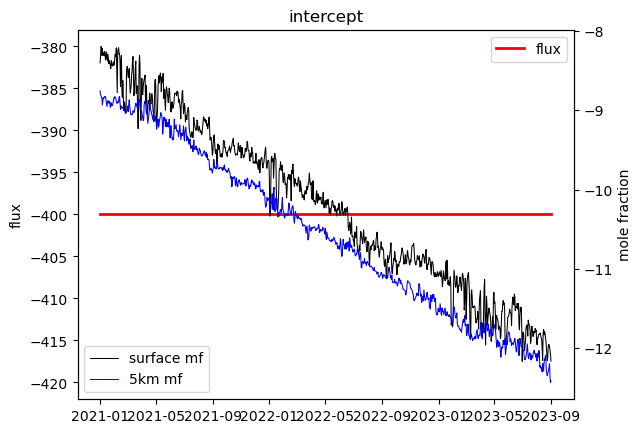

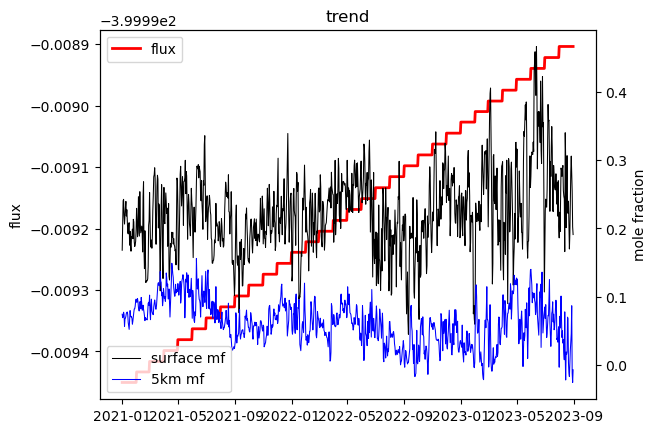

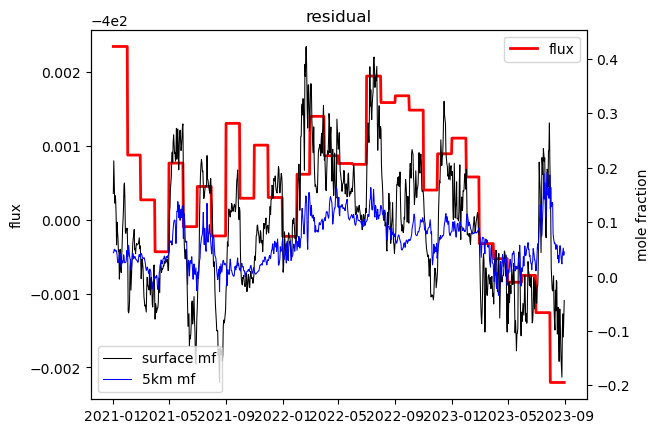

In [27]:
for comp in ['intercept', 'trend', 'residual']:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(timef, ocean_flux_1d_surf[comp], '-r', lw=2, label='flux')
    ax.set_ylabel('flux')
    ax2 = ax.twinx()
    ax2.plot(time, ocean_mf_1d_surf[comp], '-k', lw=0.75, label='surface mf')
    ax2.plot(time, ocean_mf_1d_5km[comp], '-b', lw=0.75, label='5km mf')
    ax2.set_ylabel('mole fraction')
    ax.set_title(comp)
    ax.legend()
    ax2.legend(loc='lower left')